# Simulate molecular ground state with quantum algorithms

In this example, we'll simulate the molecular ground state of caffeine and hydrogen (H2) using Quantum Phase Estimation (QPE) and Variational Quantum Eigensolver (VQE). We'll show how many quantum resources (qubits, gates) the different approaches require and run the results on a quantum simulator.

To read more about these two algorithms, take a look at our blog post on the Q# Dev blog: [Quantum developer tools for chemistry](https://devblogs.microsoft.com/qsharp/quantum-developer-tools-for-chemistry/).

In [1]:
import qsharp
from qdk.chemistry import Molecule
from qdk.chemistry.broombridge import load_and_encode
qsharp.reload()
from Microsoft.Quantum.Chemistry.QPE import GetEnergyQPE
from Microsoft.Quantum.Chemistry.VQE import GetEnergyVQE

Adding package microsoft.quantum.chemistry.jupyter.

Reloading workspace.

### 1. Load molecule

In [2]:
caffeine = Molecule.from_xyz("../data/xyz/caffeine.xyz")

In [3]:
caffeine

JsmolWidget(layout=Layout(align_self='stretch', height='400px'))

In [4]:
caffeine.num_electrons

102

### 2. Load Broombridge and simulate in Q#

In [5]:
encoded_data_caffeine = load_and_encode("../data/broombridge/caffeine.yaml")

### 3. Simulate energy of Caffeine molecule

In [6]:
%%time
GetEnergyQPE.simulate(
    JWEncodedData=encoded_data_caffeine,
    nBitsPrecision=7,
    trotterStepSize=0.4,
    trotterOrder=1)

CPU times: user 2.66 ms, sys: 277 µs, total: 2.94 ms
Wall time: 655 ms


883.8467931351445

In [18]:
%%time
resources_caffeine_qpe = GetEnergyQPE.estimate_resources(
    JWEncodedData=encoded_data_caffeine, 
    nBitsPrecision=7,
    trotterStepSize=0.4, 
    trotterOrder=1)
resources_caffeine_qpe

CPU times: user 3.06 ms, sys: 373 µs, total: 3.43 ms
Wall time: 1.49 s


{'CNOT': 211616,
 'QubitClifford': 124794,
 'R': 81068,
 'Measure': 317,
 'T': 0,
 'Depth': 0,
 'Width': 5,
 'QubitCount': 5,
 'BorrowedWidth': 0}

### 4. Compare resources to a smaller circuit (VQE)

In [48]:
GetEnergyVQE.simulate(
    JWEncodedData=encoded_data_caffeine,
    theta1=0.001,
    theta2=-0.001,
    theta3=0.001,
    nSamples=1
)

882.3912532826445

In [19]:
resources_caffeine_vqe = GetEnergyVQE.estimate_resources(
    JWEncodedData=encoded_data_caffeine,
    theta1=0.001,
    theta2=-0.001,
    theta3=0.001,
    nSamples=1
)
resources_caffeine_vqe

{'CNOT': 0,
 'QubitClifford': 52,
 'R': 0,
 'Measure': 130,
 'T': 0,
 'Depth': 0,
 'Width': 4,
 'QubitCount': 4,
 'BorrowedWidth': 0}

### Simulate a smaller molecule: H2

52 Clifford gates is still a lot of resources, and won't be feasible on near-term hardware. Let's simulate a smaller molecule to compare the required resources to caffeine.

In [9]:
H2 = Molecule.from_smiles("[H][H]")

Solution did not converge. Lowest energy found: -1.0


In [10]:
H2

JsmolWidget(layout=Layout(align_self='stretch', height='400px'))

$H_2$ has a much smaller number of electrons than caffeine, as shown below:

In [11]:
H2.num_electrons

2

In [12]:
encoded_data_h2 = load_and_encode("../data/broombridge/hydrogen_0.2.yaml")

In [22]:
%%time
GetEnergyQPE.simulate(
    JWEncodedData=encoded_data_h2, 
    nBitsPrecision=7,
    trotterStepSize=0.4,
    trotterOrder=1
)

CPU times: user 3.06 ms, sys: 0 ns, total: 3.06 ms
Wall time: 238 ms


-1.1419413817622361

In [21]:
resources_h2_qpe = GetEnergyQPE.estimate_resources(
    JWEncodedData=encoded_data_h2, 
    nBitsPrecision=7,
    trotterStepSize=0.4,
    trotterOrder=1
)
resources_h2_qpe

{'CNOT': 99584,
 'QubitClifford': 50106,
 'R': 43724,
 'Measure': 317,
 'T': 0,
 'Depth': 0,
 'Width': 5,
 'QubitCount': 5,
 'BorrowedWidth': 0}

In [49]:
GetEnergyVQE.simulate(
    JWEncodedData=encoded_data_h2, 
    theta1=0.001,
    theta2=-0.001,
    theta3=0.001,
    nSamples=1
)

-1.1166856359999997

In [24]:
resources_h2_vqe = GetEnergyVQE.estimate_resources(
    JWEncodedData=encoded_data_h2, 
    theta1=0.001,
    theta2=-0.001,
    theta3=0.001,
    nSamples=1
)
resources_h2_vqe

{'CNOT': 0,
 'QubitClifford': 28,
 'R': 0,
 'Measure': 70,
 'T': 0,
 'Depth': 0,
 'Width': 4,
 'QubitCount': 4,
 'BorrowedWidth': 0}

### Comparing resources

The below bar chart shows the comparison between number of Clifford gates for the different algorithms on both Caffeine and H2.

Text(0.5, 1.0, 'Resources for H2 vs Caffeine')

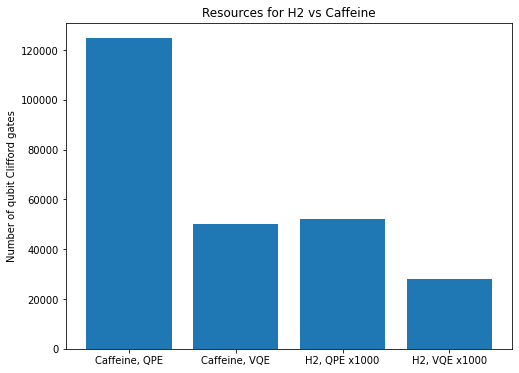

In [47]:
import matplotlib
import pylab as pl
%matplotlib inline

pl.figure(figsize=(8, 6))
pl.bar(
    [
        "Caffeine, QPE",
        "Caffeine, VQE",
        "H2, QPE x1000",
        "H2, VQE x1000",
    ],
    [
        resources_caffeine_qpe["QubitClifford"],
        resources_h2_qpe["QubitClifford"],
        resources_caffeine_vqe["QubitClifford"] * 1e3,
        resources_h2_vqe["QubitClifford"] *  1e3,
    ]
)
pl.ylabel("Number of qubit Clifford gates")
pl.title("Resources for H2 vs Caffeine")